In [16]:
import numpy as np
import pandas as pd
import nlpaug.augmenter.word as naw
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# Loading data
df = pd.read_csv('Data\\balanced_augmented_Call_Conversation(Emotion).csv')
print(df.shape)

(602, 4)


In [18]:
df.head(3)

,VoiceClip_No,TextTranscript,label,processed_content
0,Voice52,the experience was your agent responded positi...,Non,the experience was your agent responded positi...
1,Voice38,get not working all,Non,get not working all
2,Voice199,can know the current price the fiber connection,Non,can know the current price the fiber connection


In [19]:
x = df['TextTranscript']
y = df['label']

In [20]:

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [21]:
# TF-IDF Vectorization (converts the text data(comments) into numerical features)
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter grid to search
param_grid_rf = {
    'n_estimators': [100,200,300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [20,30,40],  # Minimum samples required to split a node
    'min_samples_leaf': [10,15,20]  # Minimum samples required at a leaf node
}

# Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create K-Fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with cross-validation on the training data to get the best hyperparameters
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=kf)
grid_search_rf.fit(X_train_tfidf, y_train)

# Best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest:", best_params_rf)

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 300}


In [22]:
# Training the final Random Forest model with the best hyperparameters
final_rf_classifier = RandomForestClassifier(**best_params_rf)
final_rf_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(min_samples_leaf=10, min_samples_split=20,
                       n_estimators=300)

In [23]:
y_pred_rf = final_rf_classifier.predict(X_test_tfidf)

# Evaluated the final Random Forest model on the testing dataset
report_rf = classification_report(y_test, y_pred_rf)
print("\nClassification Report for Random Forest on Testing Data:")
print(report_rf)


Classification Report for Random Forest on Testing Data:
              precision    recall  f1-score   support

         Agg       0.91      0.94      0.92        63
         Non       0.93      0.90      0.91        58

    accuracy                           0.92       121
   macro avg       0.92      0.92      0.92       121
weighted avg       0.92      0.92      0.92       121



In [24]:
# Get the accuracy score
accuracy_score(y_test, y_pred_rf)

0.9173553719008265

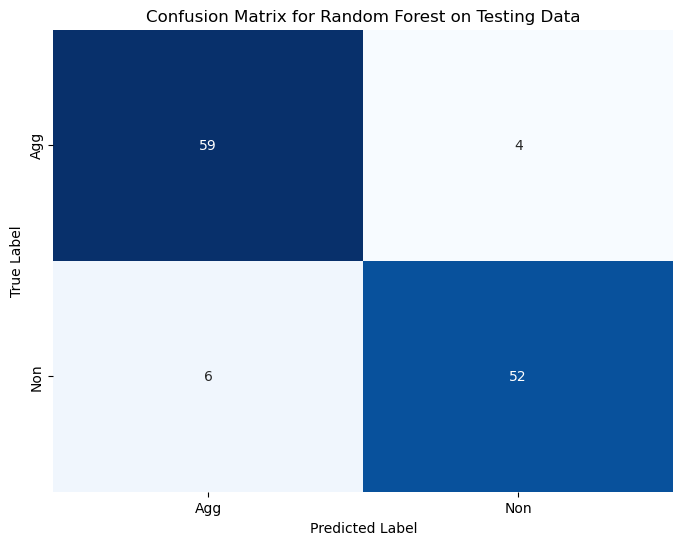

In [25]:
#Get the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=final_rf_classifier.classes_,
            yticklabels=final_rf_classifier.classes_)
plt.title('Confusion Matrix for Random Forest on Testing Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
# Predict class labels on the training dataset
y_train_pred_rf = final_rf_classifier.predict(X_train_tfidf)

# Predict class labels on the testing dataset
y_test_pred_rf = final_rf_classifier.predict(X_test_tfidf)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
print(f'\nTraining Accuracy: {train_accuracy:.4f}')

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred_rf)
print(f'TestingAccuracy: {test_accuracy:.4f}')


Training Accuracy: 0.9064
TestingAccuracy: 0.9174


In [45]:
# Predicting probabilities instead of labels for ROC curve
y_prob_rf = final_rf_classifier.predict_proba(X_test_tfidf)

# Calculate the ROC AUC score for the positive class
roc_auc = roc_auc_score(y_test, y_prob_rf[:, 1])

# Print the ROC AUC score
print(f"ROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.9759


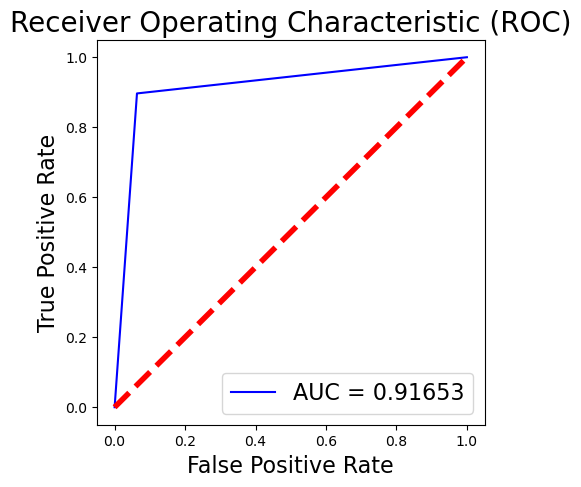

In [58]:
# ROC Curve
from sklearn.preprocessing import LabelEncoder

# Convert labels to binary format
le = LabelEncoder()
y_test_binary = le.fit_transform(y_test)
y_pred_binary = le.transform(y_pred_rf)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary, pos_label=1)
roc_auc = roc_auc_score(y_test_binary, y_pred_binary)



plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic (ROC)', size=20)
plt.plot(fpr, tpr, color='blue', label='AUC = %0.5f' % roc_auc)
plt.legend(loc='lower right', prop={'size': 16})
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=4, label='Random Chance')
plt.axis('tight')
plt.ylabel('True Positive Rate', size=16)
plt.xlabel('False Positive Rate', size=16)
plt.show()

In [28]:
Text = """can know the current price the fiber connection"""
# Used the trained model and vectorizer to get the prediction
prediction = final_rf_classifier.predict(vectorizer.transform([Text]))
# Display the prediction
print("Predicted Label:", prediction[0])

Predicted Label: Non


In [29]:
Text = """your service the worst service ever got"""
# Used the trained model and vectorizer to get the prediction
prediction = final_rf_classifier.predict(vectorizer.transform([Text]))
# Display the prediction
print("Predicted Label:", prediction[0])

Predicted Label: Agg


In [30]:
Text = """worst experience since days wifi not really they said repair going but was days still action very bad service"""
# Used the trained model and vectorizer to get the  prediction
prediction = final_rf_classifier.predict(vectorizer.transform([Text]))
# Display the prediction
print("Predicted Label:", prediction[0])

Predicted Label: Agg


In [31]:
Text = """get the text message saying this much due and you have pay something like want get bill before make the"""
# Used the trained model and vectorizer to get the  prediction
prediction = final_rf_classifier.predict(vectorizer.transform([Text]))
# Display the prediction
print("Predicted Label:", prediction[0])

Predicted Label: Non


In [32]:
import pickle
pickle.dump(final_rf_classifier, open('Models/emotion_rf_model_2.pickle','wb'))
pickle.dump(vectorizer, open('Models/emotion_vectorizer_2.pickle','wb'))